In [2]:
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import mlflow
import dagshub

dagshub.init(repo_owner='TomC333', repo_name='ml-walmart-recruiting', mlflow=True)
mlflow.set_experiment("LightGBM_Iterative_Baseline")

Accessing as TomC333

Initialized MLflow to track repo "TomC333/ml-walmart-recruiting"

Repository TomC333/ml-walmart-recruiting initialized!

<Experiment: artifact_location='mlflow-artifacts:/a6ac5c16ccea4c5bb25044e7e2926bca', creation_time=1753995797392, experiment_id='8', last_update_time=1753995797392, lifecycle_stage='active', name='LightGBM_Iterative_Baseline', tags={}>

# Load and preprocess data

In [3]:
features_data = pd.read_csv('data/features.csv')
train_data = pd.read_csv('data/train.csv')
stores = pd.read_csv('data/stores.csv')

df = train_data.merge(features_data, on=['Store', 'Date'], how='inner').merge(stores, on=['Store'], how='inner')

if 'IsHoliday_y' in df.columns:
    df.drop(['IsHoliday_y'], axis=1, inplace=True)
    df.rename(columns={'IsHoliday_x': 'IsHoliday'}, inplace=True)

df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(['Store', 'Dept', 'Date'])
df = df[df['Weekly_Sales'] >= 0]

In [4]:
print(f"Merged dataset shape: {df.shape}")
print(f"Date range: {df['Date'].min()} to {df['Date'].max()}")

Merged dataset shape: (420285, 16)
Date range: 2010-02-05 00:00:00 to 2012-10-26 00:00:00


# Step 0, use a few features

In [8]:
features_step0 = ['Store', 'Dept', 'IsHoliday']
target = 'Weekly_Sales'

X = df[features_step0]
y = df[target]

# Train-validation split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Train LightGBM with basic parameters
with mlflow.start_run(run_name="Step0_Baseline"):
    train_set = lgb.Dataset(X_train, label=y_train)
    val_set = lgb.Dataset(X_val, label=y_val)

    params = {
        "objective": "regression",
        "metric": "mae",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "learning_rate": 0.1,
        "num_leaves": 31,
        "seed": 42
    }

    model = lgb.train(
        params,
        train_set,
        valid_sets=[train_set, val_set],
        valid_names=["train", "val"],
        num_boost_round=1000
    )

    y_pred = model.predict(X_val)
    mae = mean_absolute_error(y_val, y_pred)

    mlflow.log_params(params)
    mlflow.log_metric("mae", mae)
    mlflow.lightgbm.log_model(model, "model")

    print(f"Step 0 MAE: {mae:.4f}")


2025/08/01 01:07:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Step 0 MAE: 2960.6041
🏃 View run Step0_Baseline at: https://dagshub.com/TomC333/ml-walmart-recruiting.mlflow/#/experiments/8/runs/3a51ba8221744c1f8003cc52b5d2bb02
🧪 View experiment at: https://dagshub.com/TomC333/ml-walmart-recruiting.mlflow/#/experiments/8


# Step 1, add time based features

In [9]:
# Step 1: Added explicit time-based features (Year, Month, Week, Quarter)
# to help LightGBM capture seasonal and yearly sales patterns, which
# are critical in retail time series forecasting.

In [12]:
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Week'] = df['Date'].dt.isocalendar().week
df['Quarter'] = df['Date'].dt.quarter

features_step1 = [
    'Store', 'Dept', 'IsHoliday',
    'Year', 'Month', 'Week', 'Quarter'
]

X = df[features_step1]
y = df[target]

with mlflow.start_run(run_name="Step1_Add_Time_Features"):
    train_set = lgb.Dataset(X_train, label=y_train)
    val_set = lgb.Dataset(X_val, label=y_val)

    params = {
        "objective": "regression",
        "metric": "mae",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "learning_rate": 0.1,
        "num_leaves": 31,
        "seed": 42
    }

    model = lgb.train(
        params,
        train_set,
        valid_sets=[train_set, val_set],
        valid_names=["train", "val"],
        num_boost_round=1000
    )

    y_pred = model.predict(X_val)
    mae = mean_absolute_error(y_val, y_pred)

    mlflow.log_params(params)
    mlflow.log_metric("mae", mae)
    mlflow.lightgbm.log_model(model, "model")

    print(f"Step 1 MAE: {mae:.4f}")


2025/08/01 01:13:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Step 1 MAE: 2960.6041
🏃 View run Step1_Add_Time_Features at: https://dagshub.com/TomC333/ml-walmart-recruiting.mlflow/#/experiments/8/runs/a8c35c694ea144029447b1be4b3c58cd
🧪 View experiment at: https://dagshub.com/TomC333/ml-walmart-recruiting.mlflow/#/experiments/8


# Step 2, add lag features

In [15]:
# Step 2: Added lag features for Weekly_Sales to capture temporal dependencies and seasonality.
# These lag features are essential for time series forecasting models to utilize recent sales
# trends and yearly patterns. This step helps LightGBM learn from historical sales context that
# basic store, department, and time features alone cannot provide.

In [9]:
lags = [1, 2, 3, 4, 52]

for lag in lags:
    df[f'Weekly_Sales_lag_{lag}'] = df.groupby(['Store', 'Dept'])['Weekly_Sales'].shift(lag)

# After creating lag features, you might want to drop rows with NaNs caused by lagging
df = df.dropna(subset=[f'Weekly_Sales_lag_{lag}' for lag in lags])

print("Lag features created and NaNs dropped.")

Lag features created and NaNs dropped.


2025/08/03 09:54:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Step 2 MAE: 1054.3717
🏃 View run Step2_Add_Lag_Features at: https://dagshub.com/TomC333/ml-walmart-recruiting.mlflow/#/experiments/8/runs/915c56ff394143df874d90b331b87f71
🧪 View experiment at: https://dagshub.com/TomC333/ml-walmart-recruiting.mlflow/#/experiments/8


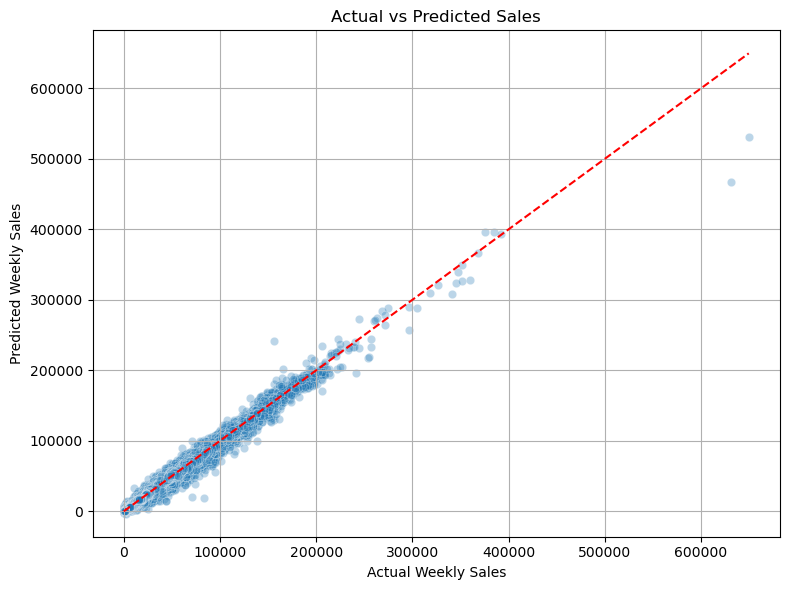

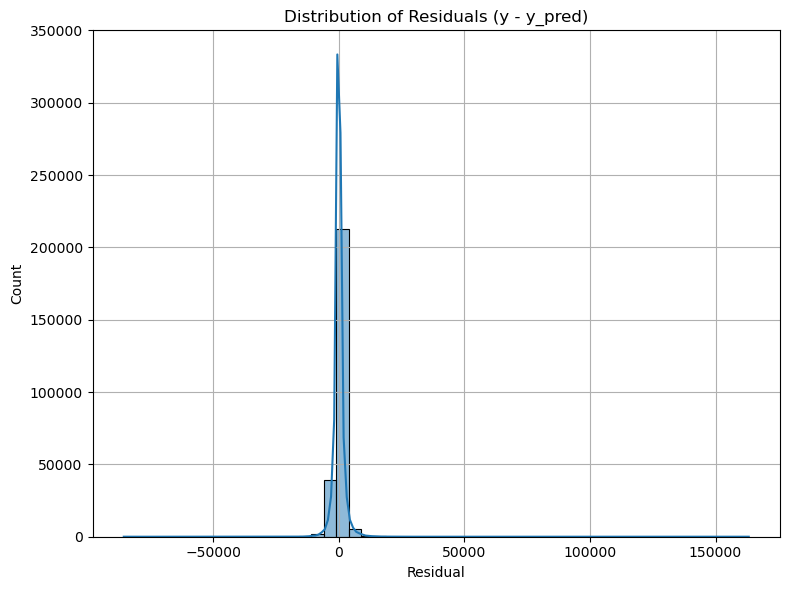

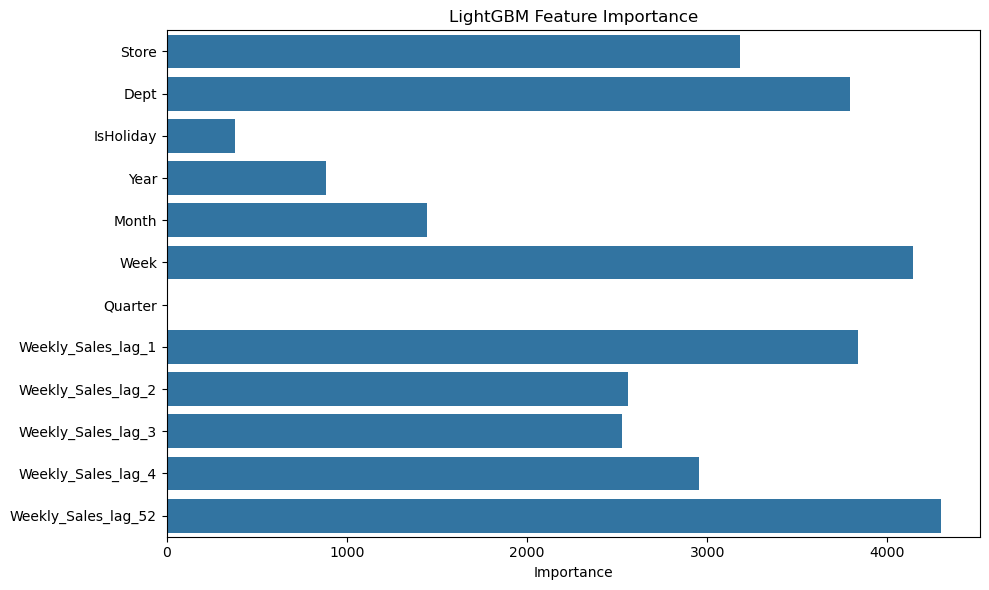

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow
import mlflow.lightgbm
import lightgbm as lgb
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error

features_step2 = [
    'Store', 'Dept', 'IsHoliday',
    'Year', 'Month', 'Week', 'Quarter',
    'Weekly_Sales_lag_1', 'Weekly_Sales_lag_2', 'Weekly_Sales_lag_3', 'Weekly_Sales_lag_4', 'Weekly_Sales_lag_52'
]

X = df[features_step2]
y = df['Weekly_Sales']

with mlflow.start_run(run_name="Step2_Add_Lag_Features"):
    lgb_train = lgb.Dataset(X, label=y)
    params = {
        'objective': 'regression',
        'metric': 'mae',
        'random_state': 42,
        'verbosity': -1,
    }
    model = lgb.train(params, lgb_train, num_boost_round=1000)
    
    preds = model.predict(X)
    mae = mean_absolute_error(y, preds)
    
    mlflow.log_params(params)
    mlflow.log_metric("MAE", mae)
    mlflow.lightgbm.log_model(model, "model")
    
    print(f"Step 2 MAE: {mae:.4f}")
    
    # 1. Actual vs Predicted
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=y, y=preds, alpha=0.3)
    plt.xlabel("Actual Weekly Sales")
    plt.ylabel("Predicted Weekly Sales")
    plt.title("Actual vs Predicted Sales")
    plt.grid(True)
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
    plt.tight_layout()
    plt.savefig("actual_vs_pred.png")
    mlflow.log_artifact("actual_vs_pred.png")
    
    # 2. Residual Plot
    residuals = y - preds
    plt.figure(figsize=(8, 6))
    sns.histplot(residuals, bins=50, kde=True)
    plt.title("Distribution of Residuals (y - y_pred)")
    plt.xlabel("Residual")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("residuals.png")
    mlflow.log_artifact("residuals.png")
    
    # 3. Feature Importance
    importances = model.feature_importance()
    feature_names = model.feature_name()
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x=importances, y=feature_names, orient="h")
    plt.title("LightGBM Feature Importance")
    plt.xlabel("Importance")
    plt.tight_layout()
    plt.savefig("feature_importance.png")
    mlflow.log_artifact("feature_importance.png")

    

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow
import mlflow.lightgbm
import lightgbm as lgb
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error

# 1. Actual vs Predicted
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y, y=preds, alpha=0.3)
plt.xlabel("Actual Weekly Sales")
plt.ylabel("Predicted Weekly Sales")
plt.title("Actual vs Predicted Sales")
plt.grid(True)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.tight_layout()
plt.savefig("actual_vs_pred.png")
mlflow.log_artifact("actual_vs_pred.png")

# 2. Residual Plot
residuals = y - preds
plt.figure(figsize=(8, 6))
sns.histplot(residuals, bins=50, kde=True)
plt.title("Distribution of Residuals (y - y_pred)")
plt.xlabel("Residual")
plt.grid(True)
plt.tight_layout()
plt.savefig("residuals.png")
mlflow.log_artifact("residuals.png")

# 3. Feature Importance
importances = model.feature_importance()
feature_names = model.feature_name()

plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=feature_names, orient="h")
plt.title("LightGBM Feature Importance")
plt.xlabel("Importance")
plt.tight_layout()
plt.savefig("feature_importance.png")
mlflow.log_artifact("feature_importance.png")


NameError: name 'preds' is not defined

<Figure size 800x600 with 0 Axes>

# Step 3, add external factors

In [19]:
# Step 3: Create holiday flag features for Super Bowl, Labor Day, Thanksgiving, and Christmas
# These flags identify weeks with major holidays known to impact sales significantly
# Adding these features helps the model capture important seasonal effects and promotional periods

In [18]:
superbowl_dates = pd.to_datetime(['2010-02-12', '2011-02-11', '2012-02-10', '2013-02-08'])
laborday_dates = pd.to_datetime(['2010-09-10', '2011-09-09', '2012-09-07', '2013-09-06'])
thanksgiving_dates = pd.to_datetime(['2010-11-26', '2011-11-25', '2012-11-23', '2013-11-29'])
christmas_dates = pd.to_datetime(['2010-12-31', '2011-12-30', '2012-12-28', '2013-12-27'])

# Create new columns initialized with 0
df['Is_SuperBowl'] = 0
df['Is_LaborDay'] = 0
df['Is_Thanksgiving'] = 0
df['Is_Christmas'] = 0

# Mark holiday weeks
df.loc[df['Date'].isin(superbowl_dates), 'Is_SuperBowl'] = 1
df.loc[df['Date'].isin(laborday_dates), 'Is_LaborDay'] = 1
df.loc[df['Date'].isin(thanksgiving_dates), 'Is_Thanksgiving'] = 1
df.loc[df['Date'].isin(christmas_dates), 'Is_Christmas'] = 1

/var/folders/91/01r863q91sz9mhh3gsvm_d640000gn/T/ipykernel_15828/4033445276.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Is_SuperBowl'] = 0
/var/folders/91/01r863q91sz9mhh3gsvm_d640000gn/T/ipykernel_15828/4033445276.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Is_LaborDay'] = 0
/var/folders/91/01r863q91sz9mhh3gsvm_d640000gn/T/ipykernel_15828/4033445276.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

In [20]:
features_step3 = [
    'Store', 'Dept', 'IsHoliday',
    'Year', 'Month', 'Week', 'Quarter',
    'Weekly_Sales_lag_1', 'Weekly_Sales_lag_2', 'Weekly_Sales_lag_3', 'Weekly_Sales_lag_4', 'Weekly_Sales_lag_52',
    'Is_SuperBowl', 'Is_LaborDay', 'Is_Thanksgiving', 'Is_Christmas'
]

X = df[features_step3]
y = df['Weekly_Sales']

with mlflow.start_run(run_name="Step3_Add_Holiday_Flags"):
    lgb_train = lgb.Dataset(X, label=y)
    params = {
        'objective': 'regression',
        'metric': 'mae',
        'random_state': 42,
        'verbosity': -1,
    }
    model = lgb.train(params, lgb_train, num_boost_round=1000)
    
    preds = model.predict(X)
    mae = mean_absolute_error(y, preds)
    
    mlflow.log_params(params)
    mlflow.log_metric("MAE", mae)
    mlflow.lightgbm.log_model(model, "model")
    
    print(f"Step 3 MAE: {mae:.4f}")


2025/08/01 01:28:00 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Step 3 MAE: 1050.0214
🏃 View run Step3_Add_Holiday_Flags at: https://dagshub.com/TomC333/ml-walmart-recruiting.mlflow/#/experiments/8/runs/b47dc9bcd1bd4aa4a83f01890ad29a46
🧪 View experiment at: https://dagshub.com/TomC333/ml-walmart-recruiting.mlflow/#/experiments/8


# Step 4, more lag features

In [24]:
# Step 4: Created external lag features (lags 1 and 2) for Temperature, Fuel_Price, CPI, and Unemployment 
# to capture delayed economic and environmental effects on sales.

In [ ]:
external_cols = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment']

for col in external_cols:
    df[f'{col}_lag_1'] = df.groupby('Store')[col].shift(1)
    df[f'{col}_lag_2'] = df.groupby('Store')[col].shift(2)

df = df.dropna(subset=[f'{col}_lag_1' for col in external_cols] + [f'{col}_lag_2' for col in external_cols])

In [23]:
features_step4 = [
    'Store', 'Dept', 'IsHoliday',
    'Year', 'Month', 'Week', 'Quarter',
    'Weekly_Sales_lag_1', 'Weekly_Sales_lag_2', 'Weekly_Sales_lag_3', 'Weekly_Sales_lag_4', 'Weekly_Sales_lag_52',
    'Is_SuperBowl', 'Is_LaborDay', 'Is_Thanksgiving', 'Is_Christmas',
    'Temperature_lag_1', 'Fuel_Price_lag_1', 'CPI_lag_1', 'Unemployment_lag_1',
    'Temperature_lag_2', 'Fuel_Price_lag_2', 'CPI_lag_2', 'Unemployment_lag_2'
]

X = df[features_step4]
y = df['Weekly_Sales']

with mlflow.start_run(run_name="Step4_Add_External_Lag_Features"):
    lgb_train = lgb.Dataset(X, label=y)
    params = {
        'objective': 'regression',
        'metric': 'mae',
        'random_state': 42,
        'verbosity': -1,
    }
    model = lgb.train(params, lgb_train, num_boost_round=1000)

    preds = model.predict(X)
    mae = mean_absolute_error(y, preds)

    mlflow.log_params(params)
    mlflow.log_metric("MAE", mae)
    mlflow.lightgbm.log_model(model, "model")

    print(f"Step 4 MAE: {mae:.4f}")


2025/08/01 01:33:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Step 4 MAE: 1018.8404
🏃 View run Step4_Add_External_Lag_Features at: https://dagshub.com/TomC333/ml-walmart-recruiting.mlflow/#/experiments/8/runs/25b219eec8024ebca5d7d1ed8ab4f47a
🧪 View experiment at: https://dagshub.com/TomC333/ml-walmart-recruiting.mlflow/#/experiments/8


# Step 5

In [26]:
# Step 5: Added change and percentage change features for Fuel_Price, CPI, and Unemployment
# to model trends and recent momentum in economic indicators impacting sales.

In [25]:
change_cols = ['Fuel_Price', 'CPI', 'Unemployment']

for col in change_cols:
    df[f'{col}_change'] = df.groupby('Store')[col].diff(1)
    df[f'{col}_pct_change'] = df.groupby('Store')[col].pct_change(1)
    
df = df.dropna(subset=[f'{col}_change' for col in change_cols] + [f'{col}_pct_change' for col in change_cols])

/var/folders/91/01r863q91sz9mhh3gsvm_d640000gn/T/ipykernel_15828/3589856654.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'{col}_change'] = df.groupby('Store')[col].diff(1)
/var/folders/91/01r863q91sz9mhh3gsvm_d640000gn/T/ipykernel_15828/3589856654.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'{col}_pct_change'] = df.groupby('Store')[col].pct_change(1)
/var/folders/91/01r863q91sz9mhh3gsvm_d640000gn/T/ipykernel_15828/3589856654.py:4: SettingWithCopyWarning: 
A value is trying to be set o

In [27]:
features_step5 = features_step4 + [
    'Fuel_Price_change', 'Fuel_Price_pct_change',
    'CPI_change', 'CPI_pct_change',
    'Unemployment_change', 'Unemployment_pct_change'
]

X = df[features_step5]
y = df['Weekly_Sales']

with mlflow.start_run(run_name="Step5_Add_Change_Features"):
    lgb_train = lgb.Dataset(X, label=y)
    params = {
        'objective': 'regression',
        'metric': 'mae',
        'random_state': 42,
        'verbosity': -1,
    }
    model = lgb.train(params, lgb_train, num_boost_round=1000)

    preds = model.predict(X)
    mae = mean_absolute_error(y, preds)

    mlflow.log_params(params)
    mlflow.log_metric("MAE", mae)
    mlflow.lightgbm.log_model(model, "model")

    print(f"Step 5 MAE: {mae:.4f}")

2025/08/01 01:35:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Step 5 MAE: 1014.7050
🏃 View run Step5_Add_Change_Features at: https://dagshub.com/TomC333/ml-walmart-recruiting.mlflow/#/experiments/8/runs/690917014c104d4aa808862974b31417
🧪 View experiment at: https://dagshub.com/TomC333/ml-walmart-recruiting.mlflow/#/experiments/8


# Log the best model

In [35]:
from mlflow.tracking import MlflowClient

def log_the_model(run_id, description):
    client = MlflowClient()
    
    model_uri = f"runs:/{run_id}/model"
    model_name = "Best_LightGBM_Model"
    
    try:
        client.create_registered_model(model_name)
    except mlflow.exceptions.RestException:
        pass  
    
    client.create_model_version(
        name=model_name,
        source=model_uri,
        run_id=run_id,
        # description="Final Step 5 LightGBM model with all engineered features"
        description=description
    )


# Step 6, Fix overfitting problem

In [34]:
features = [
    'Store', 'Dept',
    'IsHoliday', 'Month',
    'Weekly_Sales_lag_1', 'Weekly_Sales_lag_52',
    'CPI_lag_1', 'Unemployment_lag_1'
]

X = df[features]
y = df['Weekly_Sales']

df = df.sort_values("Date").reset_index(drop=True)

split_index = int(len(df) * 0.8)

X_train = X.iloc[:split_index]
y_train = y.iloc[:split_index]

X_val = X.iloc[split_index:]
y_val = y.iloc[split_index:]

print(f"Train dates: {df.iloc[:split_index]['Date'].min()} → {df.iloc[:split_index]['Date'].max()}")
print(f"Val dates:   {df.iloc[split_index:]['Date'].min()} → {df.iloc[split_index:]['Date'].max()}")

train_data = lgb.Dataset(X_train, label=y_train)
val_data = lgb.Dataset(X_val, label=y_val)

params = {
    'objective': 'regression',
    'metric': 'mae',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbosity': -1,
    'seed': 42
}


with mlflow.start_run(run_name="Step6_Add_Reduce_Overfitting"):
    mlflow.log_params(params)

    model = lgb.train(
        params,
        train_data,
        valid_sets=[train_data, val_data],
        valid_names=["train", "val"],
        num_boost_round=1000,
    )

    y_pred = model.predict(X_val)
    mae = mean_absolute_error(y_val, y_pred)
    
    mlflow.log_params(params)
    mlflow.log_metric("MAE", mae)
    mlflow.lightgbm.log_model(model, "model")

    print(f"Step 6 MAE: {mae:.4f}")


Train dates: 2011-02-04 00:00:00 → 2012-06-29 00:00:00
Val dates:   2012-06-29 00:00:00 → 2012-10-26 00:00:00


2025/08/01 10:06:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Step 6 MAE: 1265.4014
🏃 View run Step6_Add_Reduce_Overfitting at: https://dagshub.com/TomC333/ml-walmart-recruiting.mlflow/#/experiments/8/runs/e0aeee4b596a4c769211a2637e057511
🧪 View experiment at: https://dagshub.com/TomC333/ml-walmart-recruiting.mlflow/#/experiments/8


 # step 7, remove weekly sales lag features

In [40]:
features = [
    'Store', 'Dept', 'IsHoliday', 'Month',
    'CPI_lag_1', 'Unemployment_lag_1',
]

X = df[features]
y = df['Weekly_Sales']

df = df.sort_values("Date").reset_index(drop=True)

split_index = int(len(df) * 0.8)

X_train = X.iloc[:split_index]
y_train = y.iloc[:split_index]

X_val = X.iloc[split_index:]
y_val = y.iloc[split_index:]

print(f"Train dates: {df.iloc[:split_index]['Date'].min()} → {df.iloc[:split_index]['Date'].max()}")
print(f"Val dates:   {df.iloc[split_index:]['Date'].min()} → {df.iloc[split_index:]['Date'].max()}")

train_data = lgb.Dataset(X_train, label=y_train)
val_data = lgb.Dataset(X_val, label=y_val)

params = {
    'objective': 'regression',
    'metric': 'mae',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbosity': -1,
    'seed': 42
}


with mlflow.start_run(run_name="Step7_Add_Reduce_Overfitting"):
    mlflow.log_params(params)

    model = lgb.train(
        params,
        train_data,
        valid_sets=[train_data, val_data],
        valid_names=["train", "val"],
        num_boost_round=1000,
    )

    y_pred = model.predict(X_val)
    mae = mean_absolute_error(y_val, y_pred)
    
    mlflow.log_params(params)
    mlflow.log_metric("MAE", mae)
    mlflow.lightgbm.log_model(model, "model")

    print(f"Step 7 MAE: {mae:.4f}")


Train dates: 2011-02-04 00:00:00 → 2012-06-29 00:00:00
Val dates:   2012-06-29 00:00:00 → 2012-10-26 00:00:00


2025/08/01 10:35:15 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Step 7 MAE: 3540.5725
🏃 View run Step7_Add_Reduce_Overfitting at: https://dagshub.com/TomC333/ml-walmart-recruiting.mlflow/#/experiments/8/runs/cbdf83d626af46089fa08be33e0486d4
🧪 View experiment at: https://dagshub.com/TomC333/ml-walmart-recruiting.mlflow/#/experiments/8


In [39]:
log_the_model("ee23519b1a20488a92937e5cc5359773", "Step 7 LightGBM model")

2025/08/01 10:23:15 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Best_LightGBM_Model, version 3


# Step 8, remove CPI, Unemployment 

In [41]:
features = [
    'Store', 'Dept', 'IsHoliday', 'Month', 'Year', 'Week', 'Quarter',
    'Temperature', 'Fuel_Price', 'Size',
    'Type',
    'Is_SuperBowl', 'Is_LaborDay', 'Is_Thanksgiving', 'Is_Christmas',
    'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5',
]

for col in ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']:
    if col in df.columns:
        df[col] = df[col].fillna(0)

df['Type'] = df['Type'].astype('category')

X = df[features]
y = df['Weekly_Sales']

df = df.sort_values("Date").reset_index(drop=True)

split_index = int(len(df) * 0.8)
X_train = X.iloc[:split_index]
y_train = y.iloc[:split_index]
X_val = X.iloc[split_index:]
y_val = y.iloc[split_index:]

print(f"Train dates: {df.iloc[:split_index]['Date'].min()} → {df.iloc[:split_index]['Date'].max()}")
print(f"Val dates:   {df.iloc[split_index:]['Date'].min()} → {df.iloc[split_index:]['Date'].max()}")

train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=['Type'])
val_data = lgb.Dataset(X_val, label=y_val, categorical_feature=['Type'])

params = {
    'objective': 'regression',
    'metric': 'mae',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbosity': -1,
    'seed': 42
}

with mlflow.start_run(run_name="Step8_No_Lags_No_CPI_Unemployment"):
    mlflow.log_params(params)

    model = lgb.train(
        params,
        train_data,
        valid_sets=[train_data, val_data],
        valid_names=["train", "val"],
        num_boost_round=1000,
    )

    y_pred = model.predict(X_val)
    mae = mean_absolute_error(y_val, y_pred)

    mlflow.log_params(params)
    mlflow.log_metric("MAE", mae)
    mlflow.lightgbm.log_model(model, "model")

    print(f"Step 7 MAE: {mae:.4f}")

Train dates: 2011-02-04 00:00:00 → 2012-06-29 00:00:00
Val dates:   2012-06-29 00:00:00 → 2012-10-26 00:00:00


2025/08/01 10:38:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Step 7 MAE: 2766.1741
🏃 View run Step8_No_Lags_No_CPI_Unemployment at: https://dagshub.com/TomC333/ml-walmart-recruiting.mlflow/#/experiments/8/runs/c4270f08487c43cf8c6836b739b90f78
🧪 View experiment at: https://dagshub.com/TomC333/ml-walmart-recruiting.mlflow/#/experiments/8


In [42]:
log_the_model("c4270f08487c43cf8c6836b739b90f78", "Step 8 LightGBM model")

2025/08/01 10:40:14 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Best_LightGBM_Model, version 4


# store merged train DF 

In [29]:
import os

df_path = "train_merged_full.csv"
df.to_csv(df_path, index=False)

print(f"Saved and logged train merged dataframe at {df_path}")


Saved and logged train merged dataframe at train_merged_full.csv


In [ ]:
dagshub.init(repo_owner='TomC333', repo_name='ml-walmart-recruiting', mlflow=True
model_name = "Best_LightGBM_Model"
model_uri = f"models:/{model_name}/latest"

model = mlflow.lightgbm.load_model(model_uri)
